See `analyze-wsb-2.ipynb` for a more up-to-date version.

This will be kept for comparison for now, and likely moved to some kind of `archive` folder later.

In [ ]:
import pandas as pd
#import glob
from datetime import datetime
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint


%precision %.4f
pd.options.display.float_format = '{:,.4f}'.format
# for checking filenames from the notebook
# glob.glob('data/')

We'll use data in `data/start=2021-01-01_00:00:00_end=2021-02-01_00:00:00_n=446_seed=0`

This directory corresponds to 1% sample of 1-minute windows starting at 2021-01-01_00:00:00 and ending at
2021-02-01_00:00:00. In total, we collected all submissions from 446 such 1-minute windows.

In [ ]:
submissions = pd.read_csv('data/start=2021-01-01_00:00:00_end=2021-02-01_00:00:00_n=446_seed=0/submissions_with_praw.csv')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (78,81,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,102,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Below, we create some helpful date and time related columns, then look at some relevant descriptive stats.

* we look at the subreddits with the most posts in our sample
* we look at descriptive stats for post score and number of comments
* we look at how our posts are distributed over dates

In [ ]:
submissions['dt'] = submissions.created_utc.apply(datetime.fromtimestamp)
submissions['date'] = submissions['dt'].apply(datetime.date)
submissions['weekday'] = submissions['dt'].dt.weekday
submissions['day'] = submissions['dt'].dt.day

In [ ]:
submissions.subreddit.value_counts()[:20]

wallstreetbets        5350
HotMarthabullles      4511
AskReddit             3586
memes                 2650
u_toronto_news        2265
teenagers             1303
InspirobotBot         1256
dirtykikpals          1083
dogecoin              1028
AutoNewspaper          983
GaySnapchat            973
FreeKarma4U            955
OnlyFansPromotions     835
dankmemes              806
onlyfansgirls101       800
gonewild               773
PokemonGoFriends       769
DiscordNudes           768
DirtySnapchat          727
ksi                    724
Name: subreddit, dtype: int64

In [ ]:
submissions[['praw_num_comments', 'praw_score']].describe()

,praw_num_comments,praw_score
count,"311,091.0000","311,091.0000"
mean,5.5624,76.7681
std,79.1178,"1,254.9927"
min,0.0000,0.0000
25%,0.0000,1.0000
50%,1.0000,1.0000
75%,3.0000,10.0000
max,"38,079.0000","133,859.0000"


How many posts per day?

In [ ]:
posts_by_day = submissions.groupby('day').praw_score.count().sort_index(ascending=False).rename(index='count')

<AxesSubplot:xlabel='day', ylabel='count'>

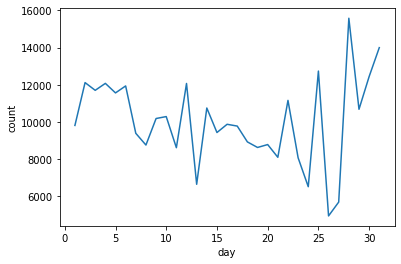

In [ ]:
sns.lineplot(data=posts_by_day)

Smell test: Is the number of posts in our sample reasonable relative to the numbers from the [2020 official reddit year in review]
(https://redditblog.com/2020/12/08/reddits-2020-year-in-review/), which suggests in 2020 Reddit recevied
303.4M submissions over 310 days (Jan 1 to Nov 6).

This should give us somewhere around 978k posts per day, or 30.318M posts in a 31-day month.

In [ ]:
n_dates = len(set(submissions.date))
n = len(submissions)
print('Posts / days')
print(n / n_dates * 100)
print('Given this is a 1% sample, our estimate for total posts in Jan 2021 is')
print(n * 100 / 1e6, 'M')

Posts / days
1031267.7419354839
Given this is a 1% sample, our estimate for total posts in Jan 2021 is
31.9693 M


Yes, the total number of posts in the sample seems plausible given the figures reported by reddit in 2020.



Next we will look at

1) all posts

2) posts from r/wallstreetbets

and calculate the mean, standard error, and 95% confidence interval for 
* score per post
* number of comments per post.

Then, we will calculate 
* a 95% confidence interval for the proportion of reddit posts from r/wallstreetbets
* estimated total number of posts from r/wallstreetbets.

In [ ]:
# create a df with just r/wallstreetbets submissions
wsb = submissions[submissions.subreddit == 'wallstreetbets']
n_wsb = len(wsb)

In [ ]:
# some useful reference points:
print('total posts: {}, total score: {}, total comments: {}'.format(
    n,
    submissions.praw_score.sum(),
    submissions.praw_num_comments.sum()
))

In [ ]:
# average post score and standard error for WSB posts
def stat_helper(name, df, full, cols):
    for col in cols:
        mean = df[col].mean()
        sem = df[col].sem()
        total = full[col].sum()
        print(name, col)
        print('mean is {:.2f} and corresponding standard error is {:.2f}'.format(
            mean, sem
        ))
        ci_lo = mean-1.95*sem
        ci_hi = mean+1.95*sem
        print('95% CI: {:.2f}, {:.2f}'.format(
            ci_lo, ci_hi 
        ))
        print('In terms of percent of the Jan 2021 sum, mean: {:.2f} sem: {:.2f}, ci: {:.2f}, {:.2f}'.format(
            mean*len(df)/total*100, sem*len(df)/total*100, ci_lo*len(df)/total * 100, ci_hi*len(df)/total*100
        ))
        print()
stat_helper('All Submissions', submissions, submissions, ['praw_score', 'praw_num_comments'])
stat_helper('r/wallstreetbets Submissions', wsb, submissions, ['praw_score', 'praw_num_comments'])


All Submissions praw_score
mean is 76.77 and corresponding standard error is 2.25
95% CI: 72.38, 81.16
In terms of percent of the Jan 2021 sum, mean: 102.77 sem: 3.01, ci: 96.89, 108.64

All Submissions praw_num_comments
mean is 5.56 and corresponding standard error is 0.14
95% CI: 5.29, 5.84
In terms of percent of the Jan 2021 sum, mean: 102.77 sem: 2.62, ci: 97.65, 107.88

r/wallstreetbets Submissions praw_score
mean is 35.45 and corresponding standard error is 8.52
95% CI: 18.84, 52.06
In terms of percent of the Jan 2021 sum, mean: 0.79 sem: 0.19, ci: 0.42, 1.17

r/wallstreetbets Submissions praw_num_comments
mean is 3.15 and corresponding standard error is 0.39
95% CI: 2.38, 3.91
In terms of percent of the Jan 2021 sum, mean: 0.97 sem: 0.12, ci: 0.74, 1.21



In [ ]:
# Look at score and num_comments from the pushshift snapshot
# (score will be lower than PRAW, but comments may be higher assuming
# some comments are deleted)
stat_helper('r/wallstreetbets Submissions', wsb, submissions, ['score', 'num_comments'])

r/wallstreetbets Submissions score
mean is 5.21 and corresponding standard error is 2.23
95% CI: 0.87, 9.55
In terms of percent of the Jan 2021 sum, mean: 2.39 sem: 1.02, ci: 0.40, 4.38

r/wallstreetbets Submissions num_comments
mean is 3.60 and corresponding standard error is 0.44
95% CI: 2.74, 4.46
In terms of percent of the Jan 2021 sum, mean: 1.06 sem: 0.13, ci: 0.81, 1.32



In [ ]:
print('r/wallstreets has {:.2f} submissions in our sample and makes up {:.2f} percent of the sample'.format(
    n_wsb, n_wsb / len(submissions)*100
))
print('Because this is a 1% sample, we estimate that r/wallstreetbets had {:.2f} of {:.2f} total submissions.'.format(
    n_wsb*100, n*100
))
ci_low, ci_upp = proportion_confint(n_wsb, n, alpha=0.05, method='normal')
print('95% CI for proportion: {:.2f}, {:.2f}'.format(ci_low*100, ci_upp*100))
print('95% CI as count: {:.2f}, {:.2f}'.format(ci_low*n*100, ci_upp*n*100))

r/wallstreets has 5350.00 submissions in our sample and makes up 1.67 percent of the sample
Because this is a 1% sample, we estimate that r/wallstreetbets had 535000.00 of 31969300.00 total submissions.
95% CI for proportion: 1.63, 1.72
95% CI as count: 520784.56, 549215.44


What are the subreddits with the most submissions, post score, and number of comments?

Let's look at the top ten for each.

First, top subreddits by summed post score from our sample. Below values show
each subreddit's percent of total Jan 2021 post score.

In [ ]:
submissions.groupby('subreddit').praw_score.sum().sort_values(ascending=False)[:10] * 100 / submissions.praw_score.sum()

subreddit
memes               10.0780
politics             2.1209
nextfuckinglevel     1.8017
dankmemes            1.6541
aww                  1.6418
interestingasfuck    1.3689
MadeMeSmile          0.8750
funny                0.8466
Minecraft            0.8376
wallstreetbets       0.7942
Name: praw_score, dtype: float64

Next, top subreddit by total number of comments in our sample. Similarly, the values below show
each subreddit's percent of (estimated) total Jan 2021 comments. 

In [ ]:
submissions.groupby('subreddit').praw_num_comments.sum().sort_values(ascending=False)[:10] * 100 / submissions.praw_num_comments.sum()

subreddit
neoliberal       2.2527
AskReddit        2.0334
memes            1.4345
politics         1.3327
wallstreetbets   0.9729
teenagers        0.8514
worldnews        0.7274
nba              0.6819
AmItheAsshole    0.6431
RedditSessions   0.6070
Name: praw_num_comments, dtype: float64

Finally, top subreddits by total number of posts in our sample (again, as percent of Jan 2021).

In [ ]:
submissions.groupby('subreddit').praw_num_comments.count().sort_values(ascending=False)[:10].rename(index='count') * 100 / submissions.praw_num_comments.count()

subreddit
wallstreetbets     1.7198
HotMarthabullles   1.4501
AskReddit          1.1527
memes              0.8518
u_toronto_news     0.7281
teenagers          0.4188
InspirobotBot      0.4037
dirtykikpals       0.3481
dogecoin           0.3304
AutoNewspaper      0.3160
Name: count, dtype: float64

Putting it all together, showing total post *counts* alongside score and comment *percents*.

In [ ]:
counts = submissions.groupby('subreddit').praw_score.count() * 100
counts.rename(index='count', inplace=True)
scores = submissions.groupby('subreddit').praw_score.sum() / submissions.praw_score.sum() * 100
comments = submissions.groupby('subreddit').praw_num_comments.sum() / submissions.praw_num_comments.sum() * 100
merged = pd.concat([counts, scores, comments], axis=1)
# = submissions[['subreddit', 'praw_score', 'praw_num_comments']].groupby('subreddit').sum()
merged.sort_values('praw_score', ascending=False)[:20]

,count,praw_score,praw_num_comments
subreddit,,,
memes,265000,10.0780,1.4345
politics,50600,2.1209,1.3327
nextfuckinglevel,9900,1.8017,0.4651
dankmemes,80600,1.6541,0.3215
aww,68800,1.6418,0.2839
interestingasfuck,12600,1.3689,0.3572
MadeMeSmile,8300,0.8750,0.1373
funny,47200,0.8466,0.3970
Minecraft,55800,0.8376,0.3317


So far, these results seem to suggest that during the period of "collective action"
r/wallstreet indeed received a huge amount of posts, comments,
and votes which made it one of the most active subreddits. However
r/wallstreetbets did not completely dominate activity metrics.

One puzzle is how these estimates relate to the claims from the above Mashable article about record
breaking pageviews. It could be that for this unusual, attention-grabbing action,
it may be that post score is not a good correlate for pageviews.

In other words, r/wallstreetbets may have received an unusually large amount of 
viewership, some of which did not create visible engagement.

Another way to unpack this data could be to ask, "What would Jan 2021 reddit activity totals have looked like without 
r/wallstreetbets"?

In [ ]:
total_posts_without_wsb = submissions.praw_score.count() - wsb.praw_score.count()
percent_of_submissions_from_wsb = wsb.praw_score.count() / total_posts_without_wsb * 100
percent_of_submissions_from_wsb

1.7498470928007694

In [ ]:
total_score_without_wsb = submissions.praw_score.sum() - wsb.praw_score.sum()
percent_of_score_from_wsb = wsb.praw_score.sum() / total_score_without_wsb * 100
percent_of_score_from_wsb

0.8005206437931529

Now for some napkin math / speculation.
Let's assume for January 2021, reddit expected \$9.91M in revenue
(conservatively drawing on [emarketer.com's \$119M per year estimate from 2019](https://www.emarketer.com/content/reddit-to-cross-100-million-in-ad-revenues-in-2019)).

If we make the (large) simplifying assumption that ad revenue scales with total post score 
(because post score correlates with page views, an assumption for which there is [some evidence](https://ojs.aaai.org/index.php/ICWSM/article/view/14700))
, the 0.8% increase in post score 
would correspond to an increase in revenue of \$78k (see below cell). If we were to use comment count instead
of post score, this figure would be \$96k. Of course, these figures do not account for ongoing activity (i.e. whatever happens in February)
or the long term effects of gaining completely new users.

If we were to instead use post count instead of post score, this figure would be \$170k. However, this
estimate is almost certainly the least accurate, because low score posts, including spam, likely contribute very little to revenue.

While assumption-reliant, these are nonetheless useful ballpark figures for thinking about the
incentives for platforms to scafflod and "encourage" collective action similar to this event.


In [ ]:
est_rev_using_score =9.91e6 / submissions.praw_score.sum() * wsb.praw_score.sum()

In [ ]:
est_rev_using_comment_count = 9.91e6 / submissions.praw_num_comments.sum() * wsb.praw_num_comments.sum()

In [ ]:
est_rev_using_submission_count = 9.91e6 / submissions.praw_score.count() * wsb.praw_score.count()

In [ ]:
est_rev_using_score, est_rev_using_comment_count, est_rev_using_submission_count

(78701.57345738506, 96412.86715776104, 170427.62407141319)

# Some additional interesting plots
* WSB metrics over time (recall that because this is a 1% sample, these are in units of 100s)
* ...more to come?

Text(0.5, 1.0, 'WSB # Posts')

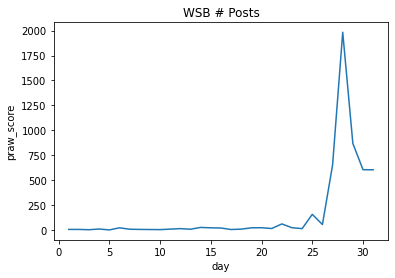

In [ ]:
ax = sns.lineplot(data=wsb.groupby('day').praw_score.count())
ax.set_title('WSB # Posts')

Text(0.5, 1.0, 'WSB Summed Scores')

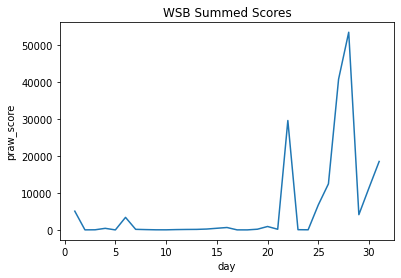

In [ ]:
ax = sns.lineplot(data=wsb.groupby('day').praw_score.sum())
ax.set_title('WSB Summed Scores')

Text(0.5, 1.0, 'WSB # Comments')

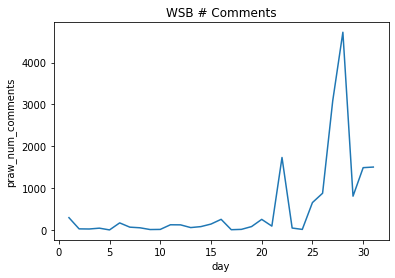

In [ ]:
ax = sns.lineplot(data=wsb.groupby('day').praw_num_comments.sum())
ax.set_title('WSB # Comments')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d8dd8e7-abf2-4721-84cd-03779d208ef5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>